In [27]:
from defs.storage_locs import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from tools.image_extract import read_frame

In [28]:
class Point():
    def __init__(self, x,y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return f"Point({self.x},{self.y})"
    
    def values(self):
        return (self.x, self.y)

class Line():
    def __init__(self, x1,y1,x2,y2):
        self.x1 = min(x1,x2)
        self.y1 = min(y1,y2)
        self.x2 = max(x1,x2)
        self.y2 = max(y1,y2)
        self.point1 = Point(x1,y1)
        self.point2 = Point(x2,y2)

        self.slope = (y2-y1)/(x2-x1)
        self.length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        self.angle = np.arctan2(y2-y1, x2-x1)
    
    def intersect(self, other_line):
        A = self.point1
        B = self.point2
        C = other_line.point1
        D = other_line.point2
        a1 = B.y - A.y
        b1 = A.x - B.x
        c1 = a1*(A.x) + b1*(A.y)
    
        # Line CD represented as a2x + b2y = c2
        a2 = D.y - C.y
        b2 = C.x - D.x
        c2 = a2*(C.x) + b2*(C.y)
    
        determinant = a1*b2 - a2*b1
    
        if (determinant == 0):
            return Point(10**9, 10**9)
        else:
            x = (b2*c1 - b1*c2)/determinant
            y = (a1*c2 - a2*c1)/determinant
            return Point(x, y)
        
    def __repr__(self):
        return f"Line({self.x1},{self.y1},{self.x2},{self.y2})"


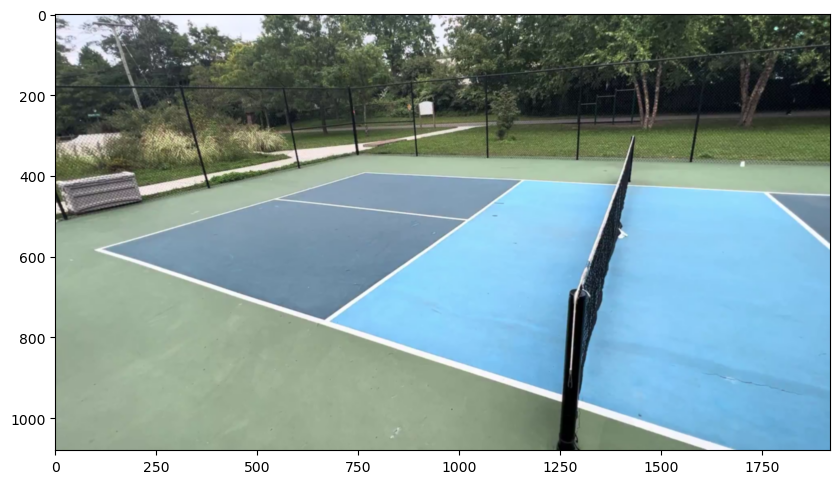

In [45]:
video_type = 'court'
video_name = 'center_left_1'
frame_num = np.random.randint(0, 1000)
img_0 = read_frame(raw_video_path(video_type, video_name), frame_num)
img_0 = cv2.GaussianBlur(img_0, (5,5), 0)
plt.figure(figsize=(10,10))
plt.imshow(img_0)
plt.show()

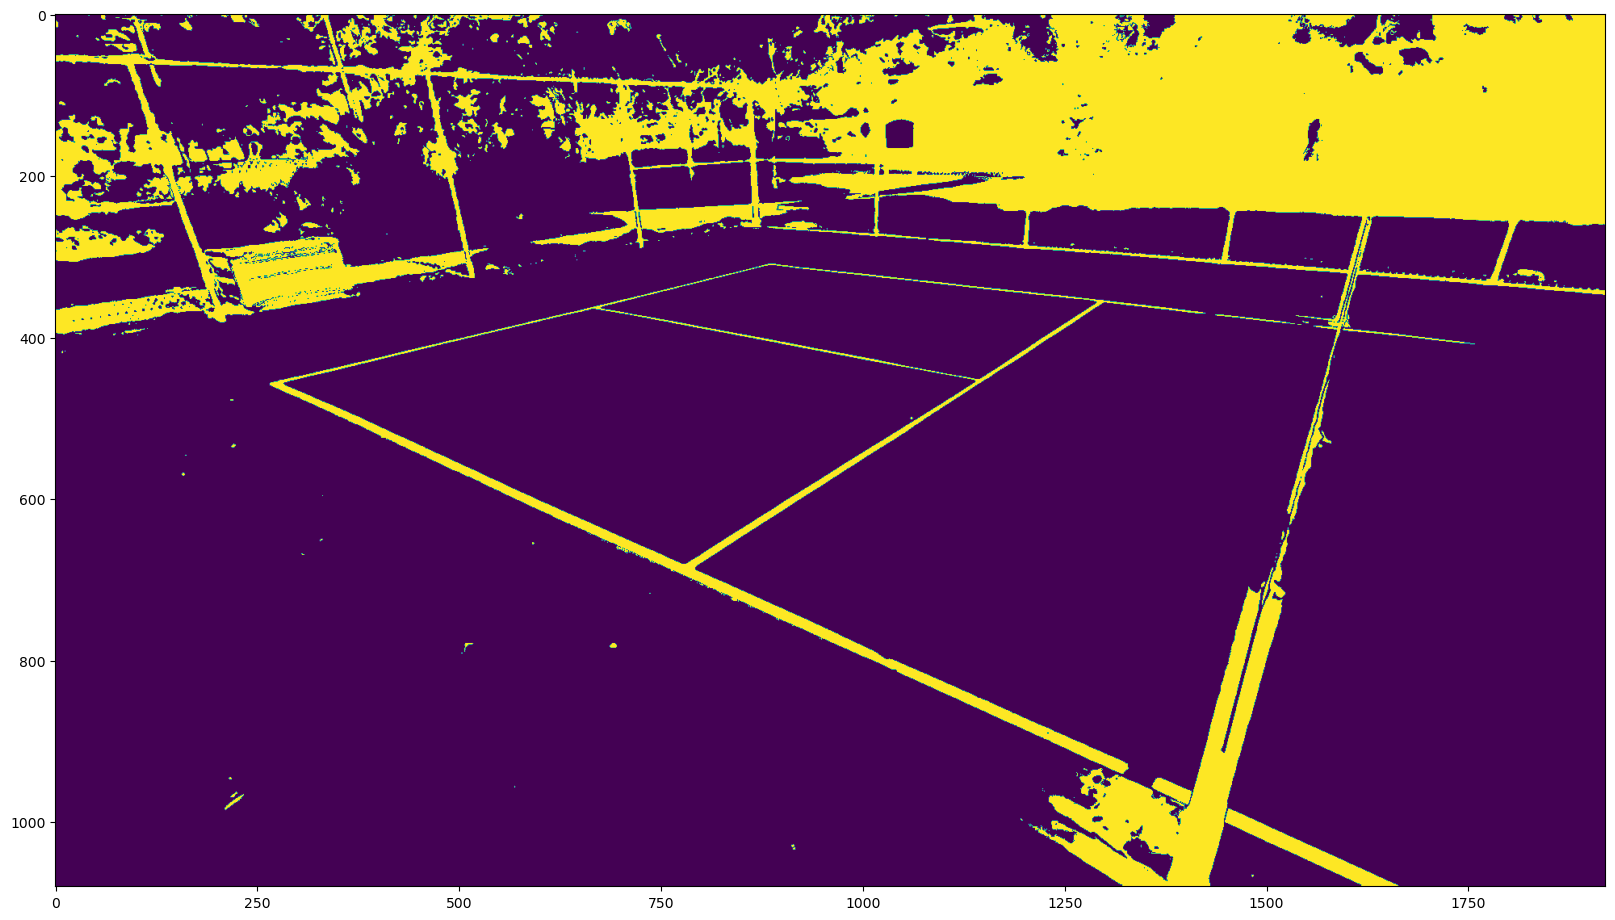

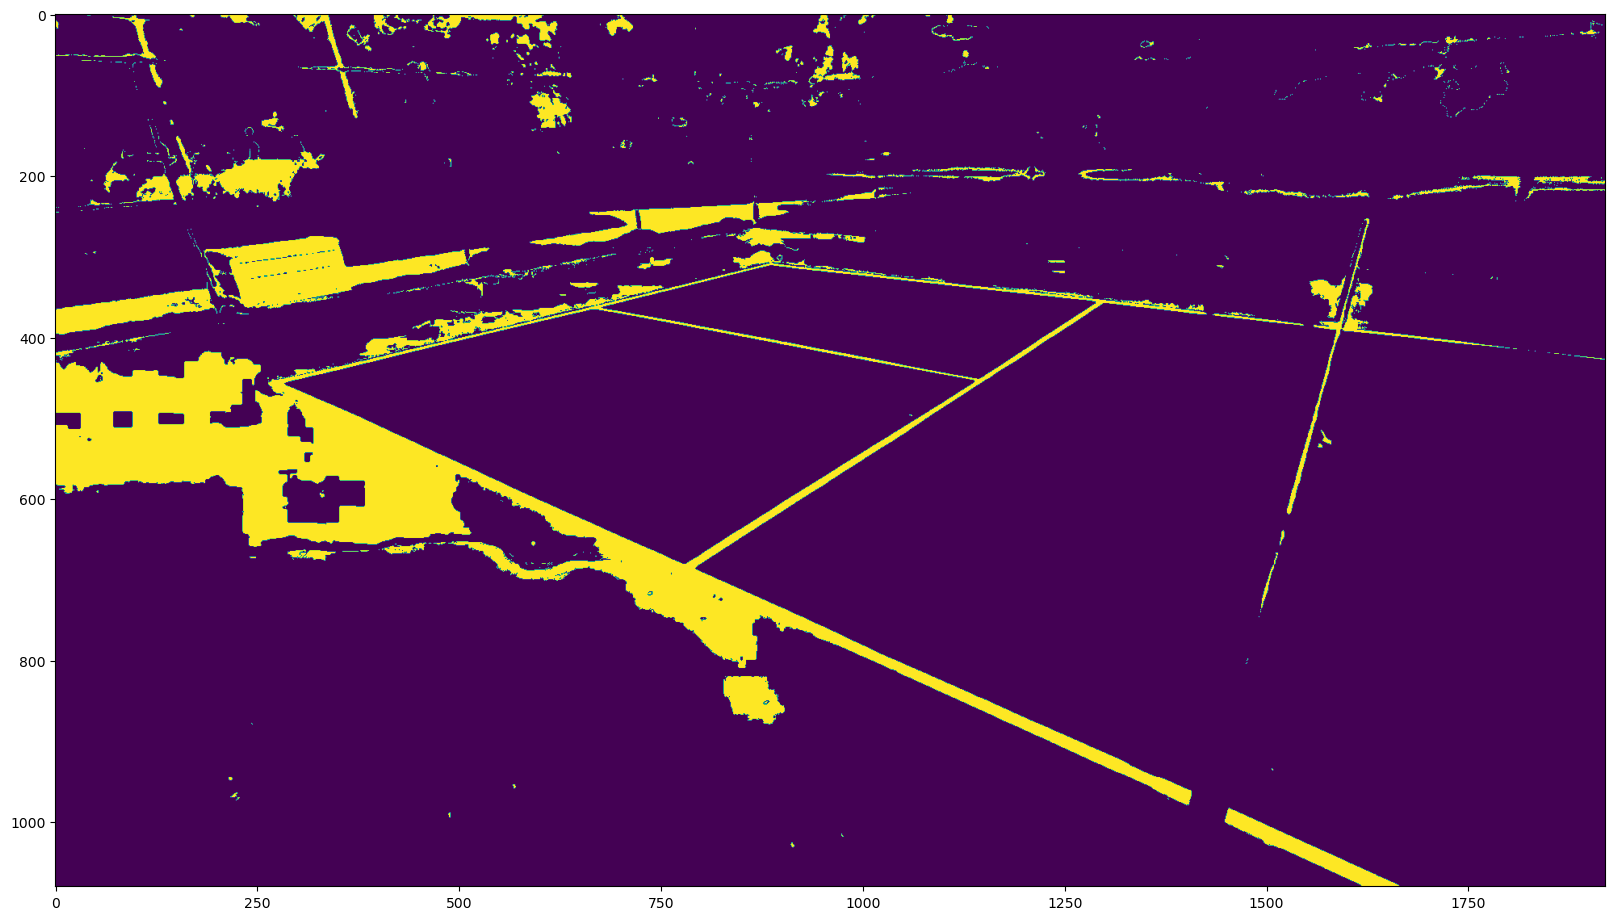

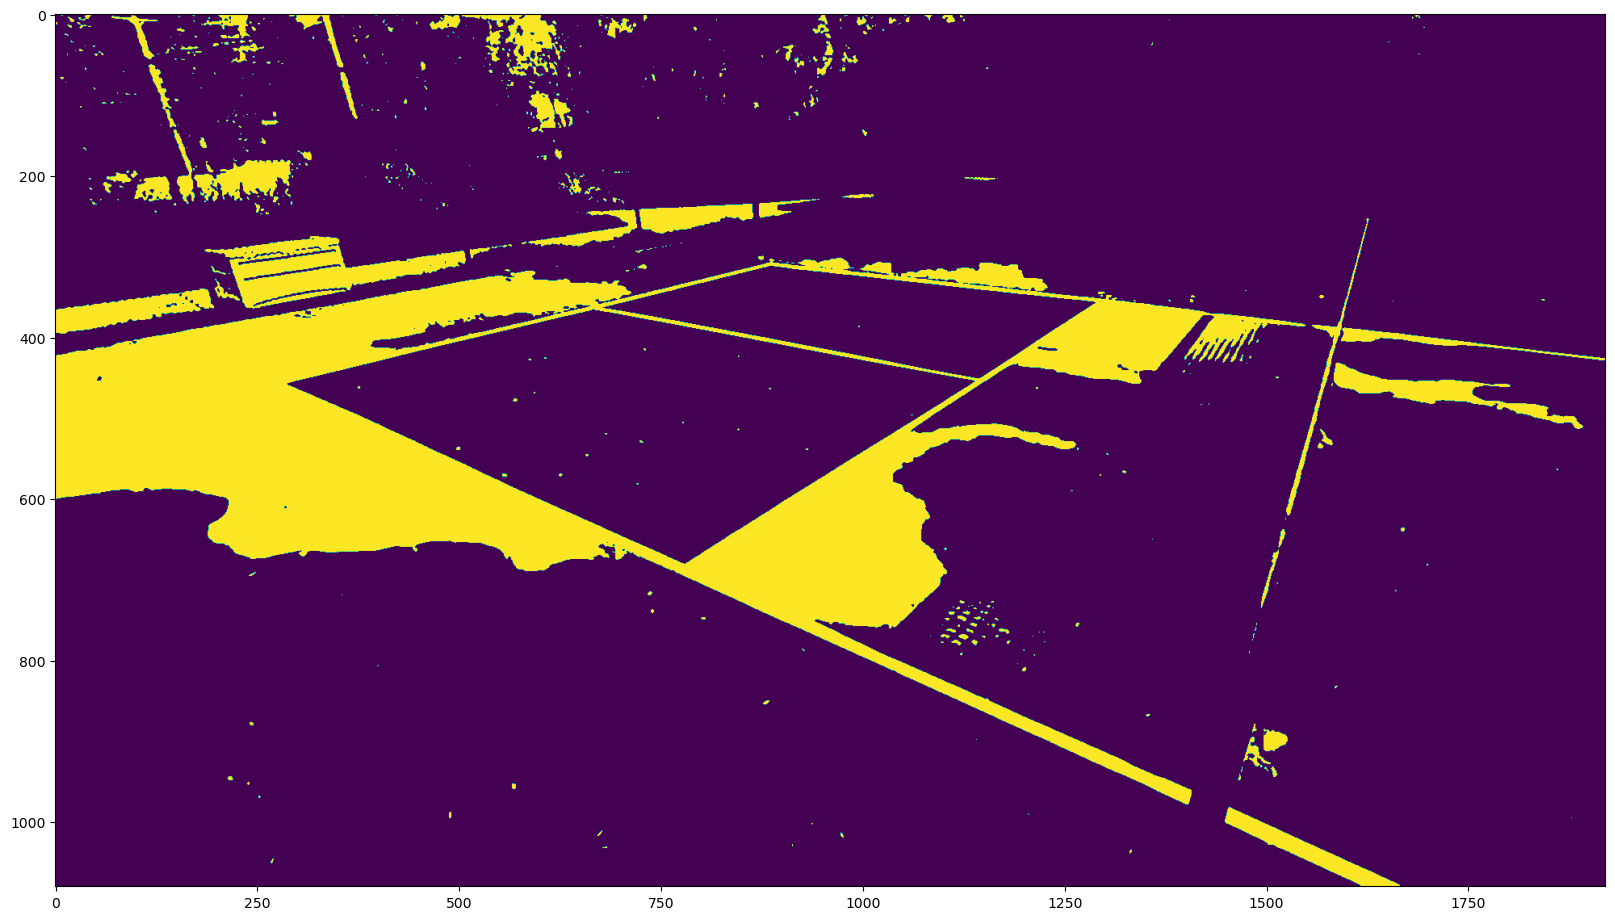

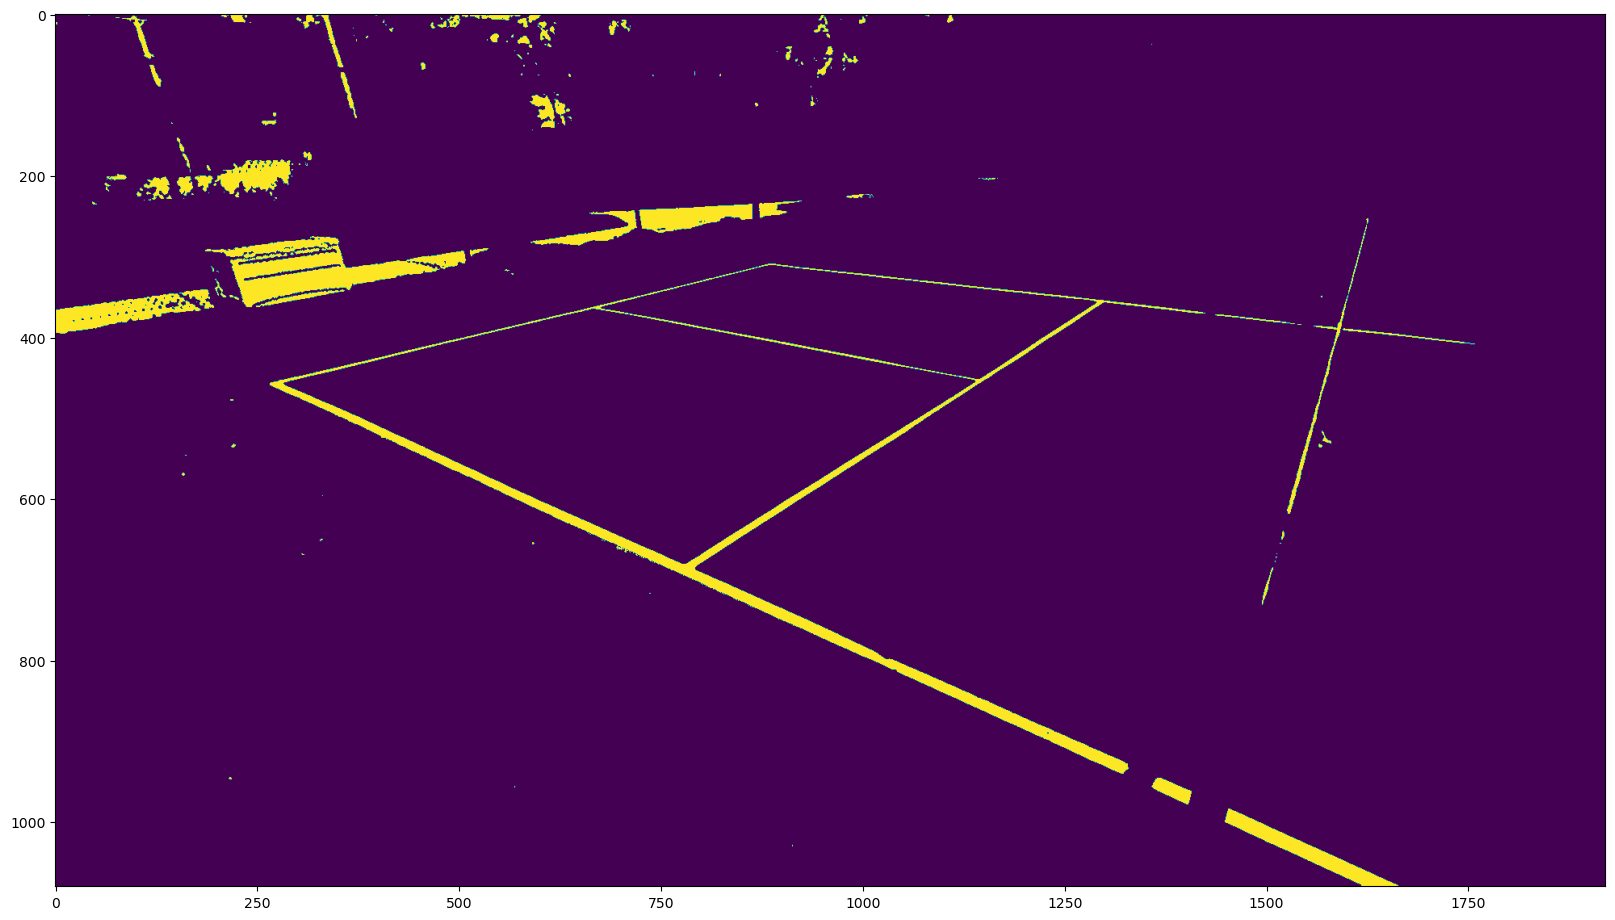

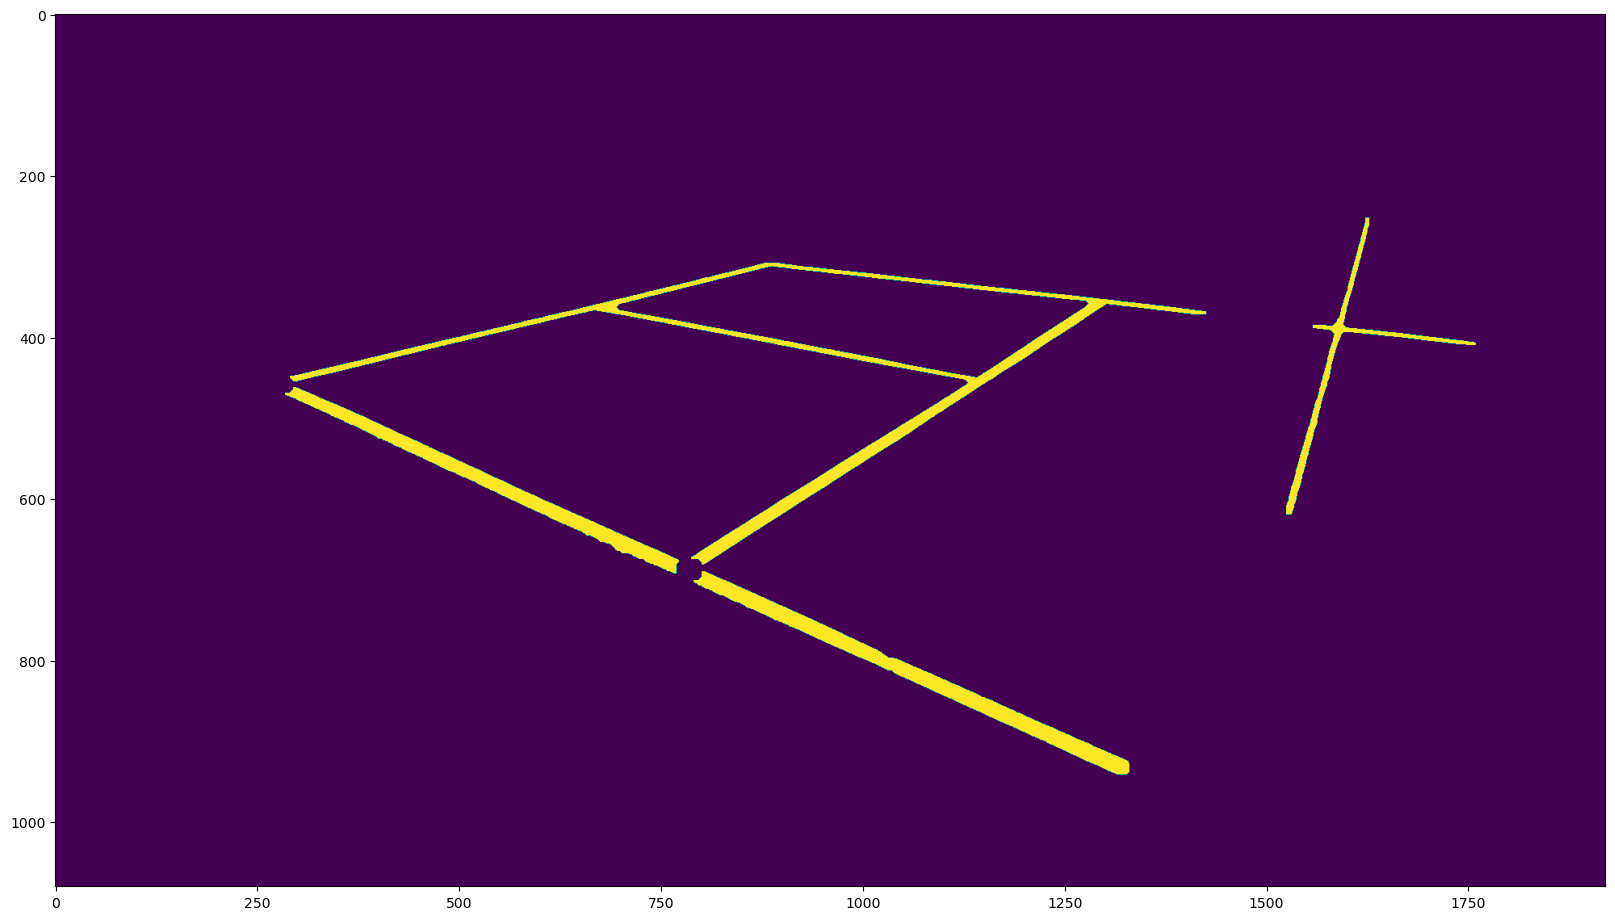

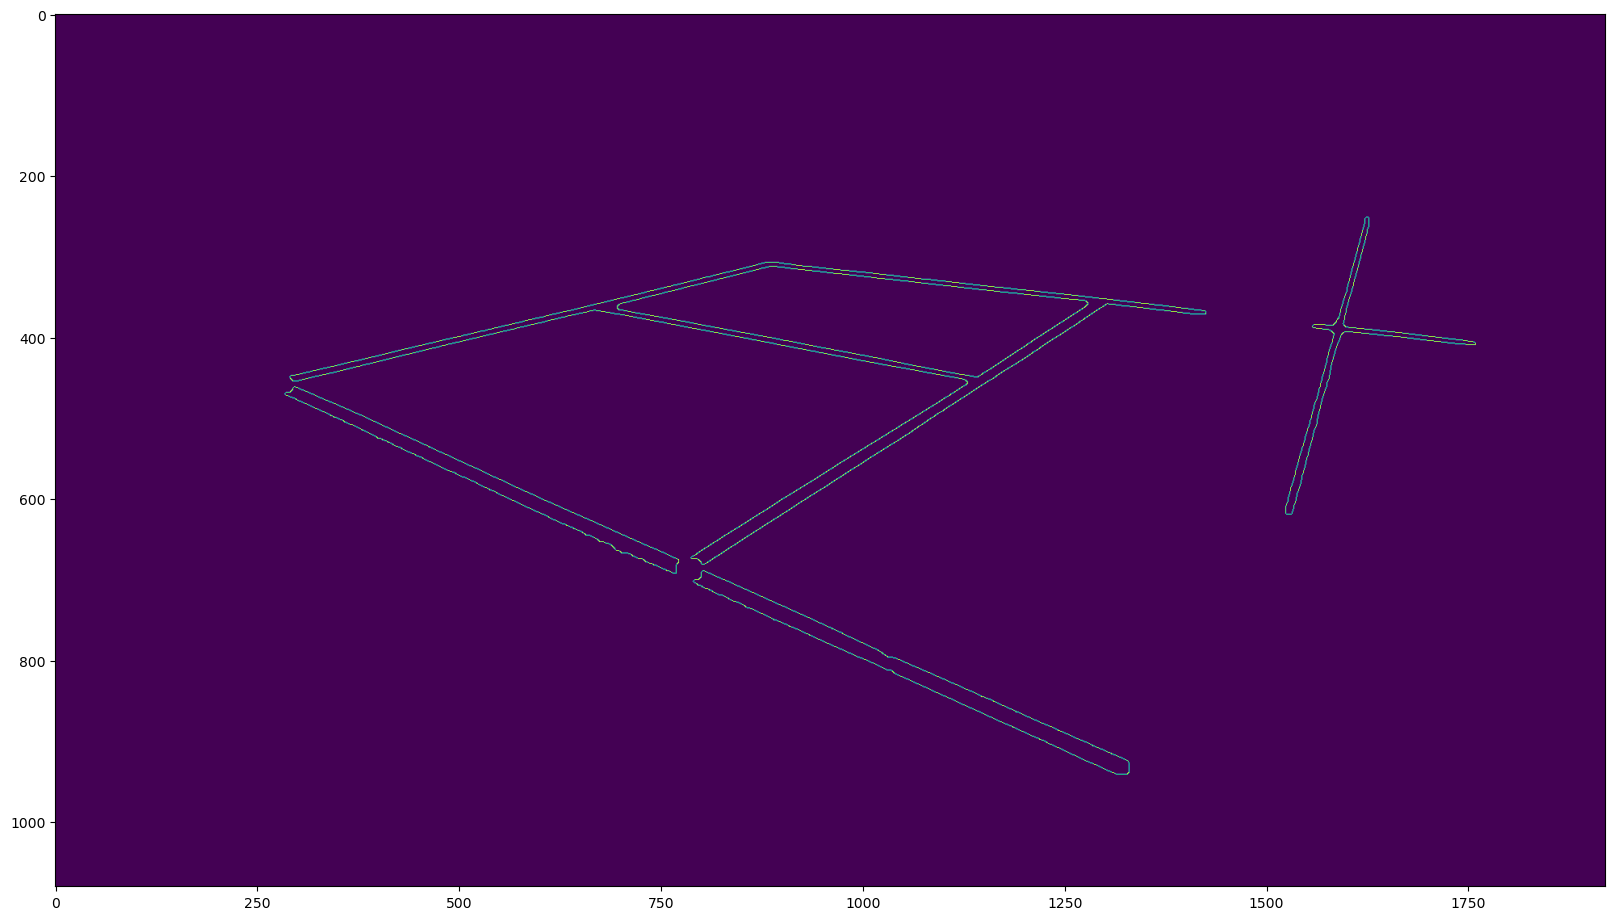

(27, 1, 4)


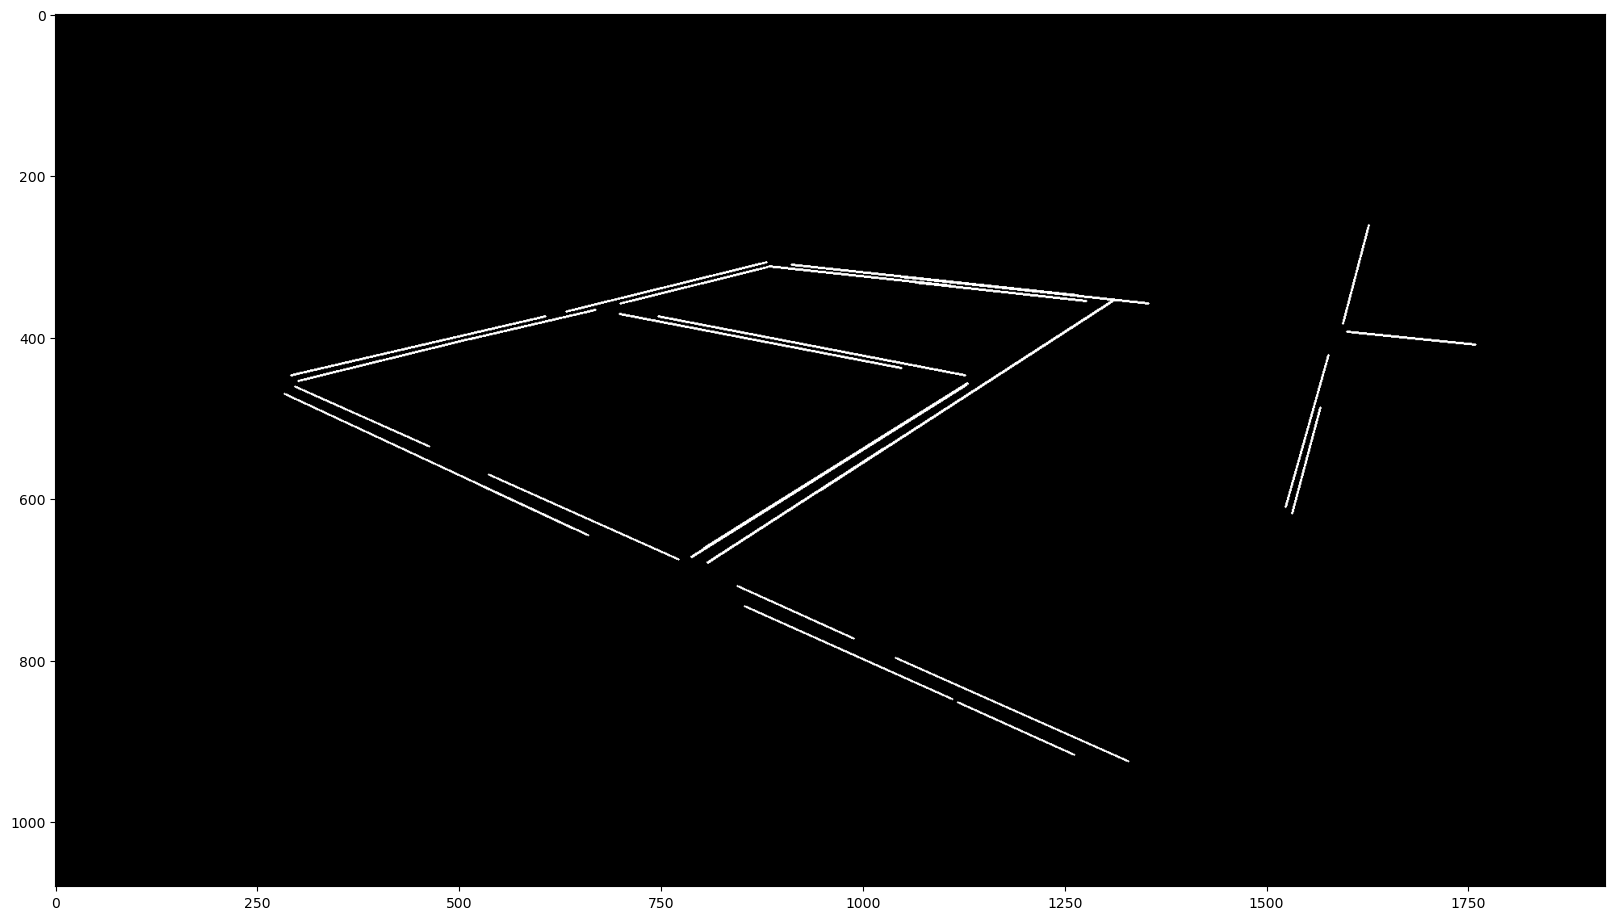

[Line(808,538,1026,679), Line(524,582,642,637), Line(537,570,772,675), Line(747,374,1127,447), Line(884,312,1109,336), Line(788,459,1128,672), Line(854,733,1111,848), Line(1065,332,1277,355), Line(845,708,989,773), Line(1047,325,1354,358), Line(292,374,607,447), Line(804,457,1130,661), Line(284,470,660,645), Line(1532,487,1567,618), Line(700,313,882,358), Line(699,371,1048,438), Line(948,354,1311,589), Line(912,310,1267,348), Line(301,401,517,454), Line(1041,797,1329,925), Line(633,307,881,368), Line(1524,422,1577,610), Line(514,366,669,402), Line(1595,261,1627,383), Line(297,461,463,535), Line(1118,852,1262,917), Line(1600,393,1759,409)]


27

In [44]:
def normalize_image(img):
    normalized = skimage.exposure.equalize_hist(img)
    return normalized

def diff_max_mask(img, threshold = 0.04):
    new_img = img.copy()
    new_img[:,:,0] = np.abs(img[:,:,0] - img[:,:,1])
    new_img[:,:,1] = np.abs(img[:,:,1] - img[:,:,2])
    new_img[:,:,2] = np.abs(img[:,:,2] - img[:,:,0])
    new_img = np.max(new_img, axis=2)
    return new_img <= threshold

def diff_from_avg_mask(img, threshold = 0.04):
    avg = np.mean(img, axis=2)
    diffs = np.square(img - np.expand_dims(avg, axis=2))/(np.expand_dims(avg, axis=2) + 1e-10)
    geom_distance = np.sqrt(np.sum(diffs, axis=2)/3)/avg
    return geom_distance <= threshold

def brightness_mask(img, threshold = 0.8):
    brightness = np.mean(img, axis=2)
    return brightness >= threshold

def show_image(img, size = (20,20), title = None):
    plt.figure(figsize=size)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

def erode_mask(mask, kernel_size = (3,3), iterations = 1, shape = cv2.MORPH_RECT):
    kernel = cv2.getStructuringElement(shape, kernel_size)
    return cv2.erode(mask.astype(np.uint8), kernel, iterations=iterations)

def dilate_mask(mask, kernel_size = (3,3), iterations = 1, shape = cv2.MORPH_RECT):
    kernel = cv2.getStructuringElement(shape, kernel_size)
    return cv2.dilate(mask.astype(np.uint8), kernel, iterations=iterations)

def remove_small_objects(mask, min_size = 100, connectivity = 2):
    return skimage.morphology.remove_small_objects(mask.astype(bool), min_size=min_size, connectivity=connectivity)

img = normalize_image(img_0)
# show_image(img)
max_mask = diff_max_mask(img)
show_image(max_mask)
avg_mask = diff_from_avg_mask(img)
show_image(avg_mask)
bright_mask = brightness_mask(img)
show_image(bright_mask)
mask = max_mask & avg_mask & bright_mask
show_image(mask)

# clean noise
mask = dilate_mask(mask, kernel_size=(3,3), iterations=2) 
mask = remove_small_objects(mask, min_size=1000, connectivity = 2)
# show_image(mask)
mask = remove_small_objects(mask, min_size=2000, connectivity = 2)
# show_image(mask)
mask = dilate_mask(mask, kernel_size=(3,3), iterations=2)
remainder = erode_mask(mask, kernel_size = (5,5), shape=cv2.MORPH_RECT, iterations = 5)
# show_image(remainder)

remainder = dilate_mask(remainder, kernel_size = (5,5), shape=cv2.MORPH_RECT, iterations = 3)
# show_image(remainder)
mask = mask * (1-remainder)
# show_image(mask)
mask = erode_mask(mask, kernel_size=(3,3), iterations=4, shape=cv2.MORPH_ELLIPSE)
# show_image(mask)
mask = dilate_mask(mask, kernel_size=(3,3), iterations=1)
# show_image(mask)
mask = remove_small_objects(mask, min_size=3000, connectivity = 2)

mask = mask.astype(np.uint8) * 255
show_image(mask)
# print(mask.max())
canny = cv2.Canny(mask, 100, 200)
show_image(canny)

lines = cv2.HoughLinesP(canny, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
print(lines.shape)
line_img = np.zeros((canny.shape[0], canny.shape[1], 3), dtype=np.uint8)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img,(x1,y1),(x2,y2),(255,255,255),2)
show_image(line_img)

line_objs = [Line(x1, y1, x2, y2) for x1,y1,x2,y2 in lines.reshape(-1,4)]
print(line_objs)
len(line_objs)


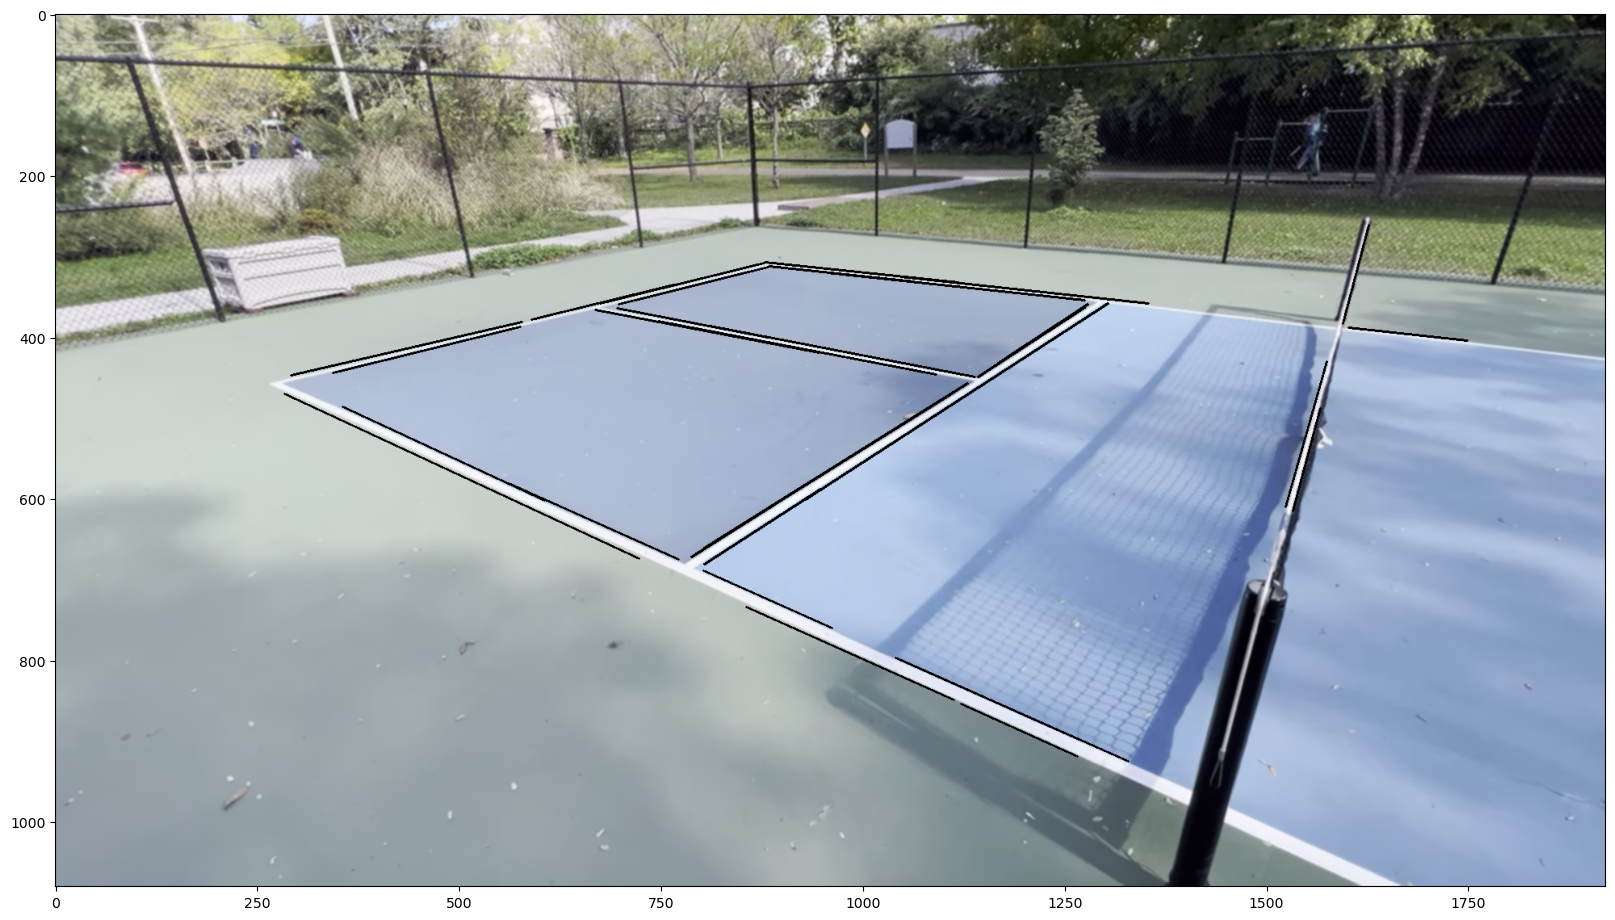

In [31]:
img_with_lines = img_0.copy()
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img_with_lines,(x1,y1),(x2,y2),(0,0,0),2)
show_image(img_with_lines)

[32.943237466167375, -24.062714725725343, -24.923938969154836, -6.025575008366681, 32.295976385943156, -10.872568606499483, -6.211822029009156, 75.01243802894318, 32.021730077686485, 12.994616791916506, -5.946863053973501, -6.135272092072481, -10.860814621637326, -24.000047657833658, 13.963348113474781, -24.10712280244722, 13.803571530623273, -6.083792378736845, 13.836839007881876, -24.891300124865822, -10.83181467497466, 74.18080605249986, 32.855721950433, -24.008901098499706, 33.08485292873498, 75.30268072048808, -24.114198539306965, 33.33122599963105, -24.293887602585066, -10.954062643398334, 13.729441690676548, 31.988712920653665]


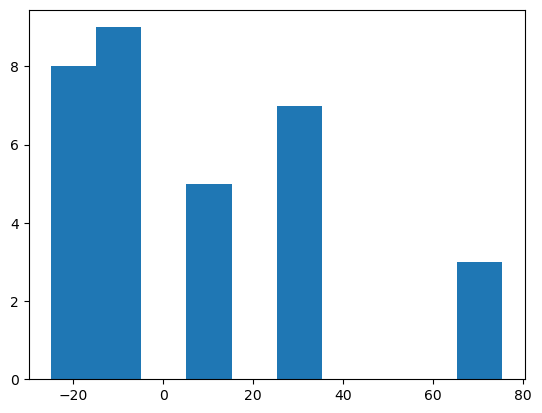

In [32]:
angles = [-line.angle * 180/np.pi for line in line_objs]

print(angles)
plt.hist(angles)
plt.show()

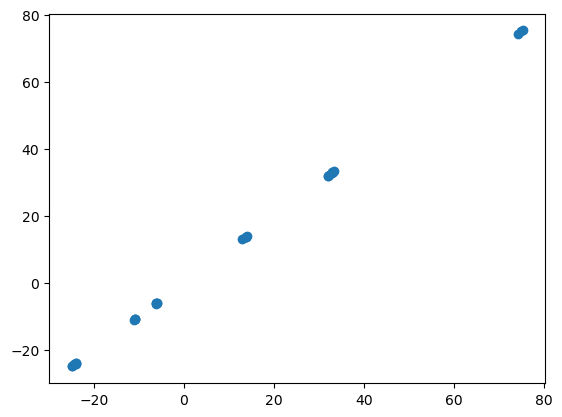

In [33]:
plt.scatter(angles, angles)

255


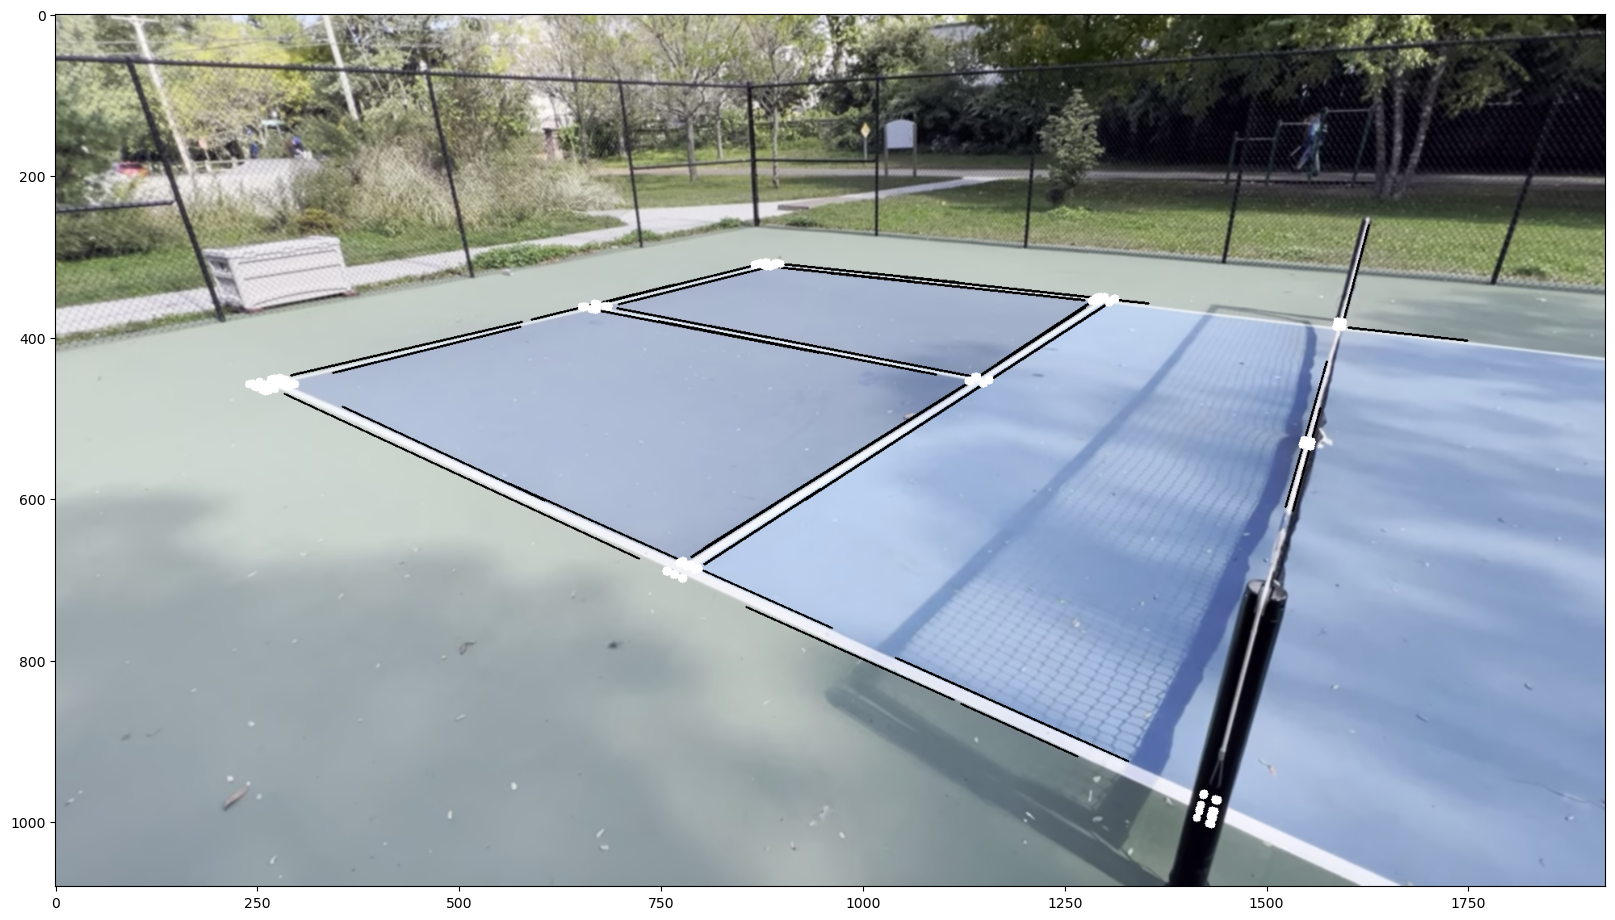

In [34]:
line_objs = [line for line in line_objs if line.x1 > 200 or line.length > 250]

intersection_points = []
for i in range(len(line_objs)):
    for j in range(i+1, len(line_objs)):
        # max_angle = 30
        # if np.abs(line_objs[i].angle - line_objs[j].angle) > max_angle * np.pi/180:
        if (line_objs[i].angle * line_objs[j].angle) < 0:
            (x,y) = line_objs[i].intersect(line_objs[j]).values()
            if x >= 0 and x < canny.shape[1] and y >= 0 and y < canny.shape[0]:
                intersection_points.append((x,y))
print(len(intersection_points))

# plot intersection points
intersection_img = img_with_lines.copy()
for x,y in intersection_points:
    cv2.circle(intersection_img, (int(x), int(y)), 5, (255,255,255), -1)
show_image(intersection_img)

            

[0 0 1 2 1 1 1 2 0 0 1 0 2 0 0 0 2 0 3 0 4 4 4 4 3 0 0 3 0 4 0 0 3 0 4 4 4
 4 3 0 0 3 0 4 0 1 5 1 6 6 6 6 5 1 1 5 1 6 1 2 1 1 1 2 0 0 1 0 2 0 0 0 2 7
 2 8 8 8 8 7 2 2 7 2 8 2 5 1 6 6 6 6 5 1 1 5 1 6 1 5 5 7 3 3 5 3 7 3 3 3 7
 1 1 2 0 0 1 0 2 0 0 0 2 6 6 8 4 4 6 4 8 4 4 4 8 6 6 6 5 1 1 5 1 6 1 6 6 6
 5 1 1 5 1 6 1 8 8 8 7 2 2 7 2 8 2 4 4 4 3 0 0 3 0 4 0 4 6 4 8 4 4 4 8 4 4
 3 0 0 3 0 4 0 6 4 8 4 4 4 8 6 5 1 1 5 1 6 1 4 8 4 4 4 8 3 0 0 3 0 4 0 7 2
 2 7 2 8 2 3 3 3 7 0 0 0 2 0 3 0 4 0 0 0 2 3 3 7 0 4 0 0 2 4 0 8 2]
9


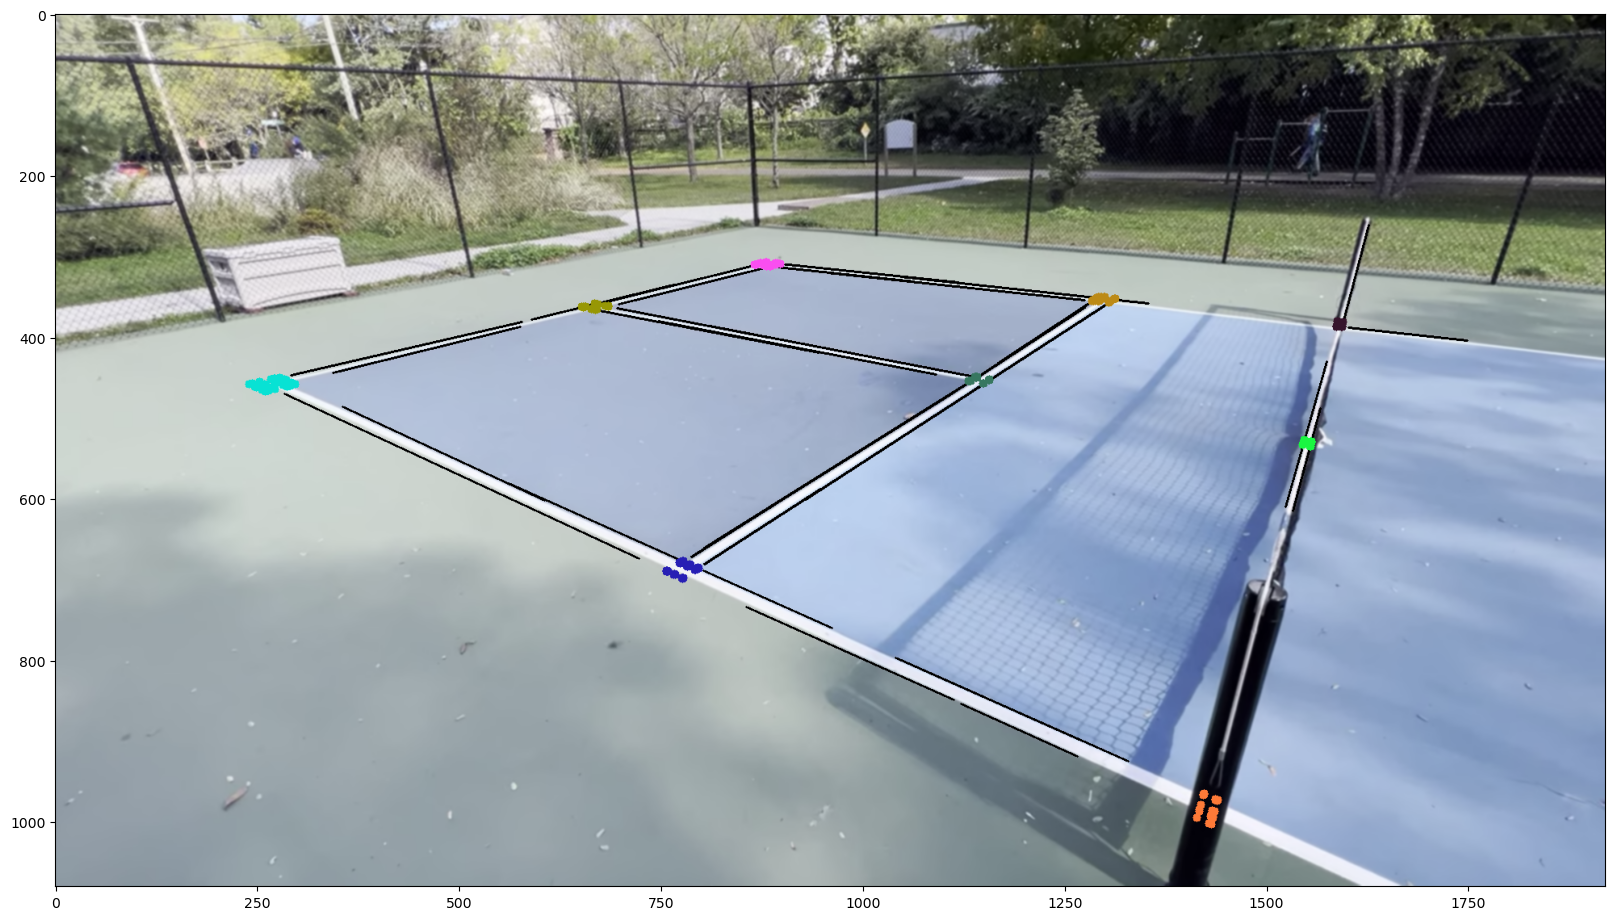

In [35]:
# cluster into groups without specifying number of clusters
from sklearn.cluster import DBSCAN

intersection_points = np.array(intersection_points)
db = DBSCAN(eps=50, min_samples=2).fit(intersection_points)
labels = db.labels_
print(labels)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

# plot clusters with different colors
cluster_img = img_with_lines.copy()
for i in range(n_clusters_):
    cluster = intersection_points[labels == i]
    color = np.random.randint(0,255,3).tolist()
    for x,y in cluster:
        cv2.circle(cluster_img, (int(x), int(y)), 5, color, -1)
show_image(cluster_img)


{0: (777.3748552303053, 688.3597328689902), 1: (1299.033961851619, 353.6555332861643), 2: (1144.9617571214344, 453.6218522942579), 3: (1427.449813883458, 984.7484284528858), 4: (269.0323118932039, 458.89194130851865), 5: (1591.292172715402, 384.46203038262234), 6: (882.6414662773741, 309.76635130625164), 7: (1551.129101199068, 531.481715749433), 8: (669.1124651080955, 362.40275644684516)}


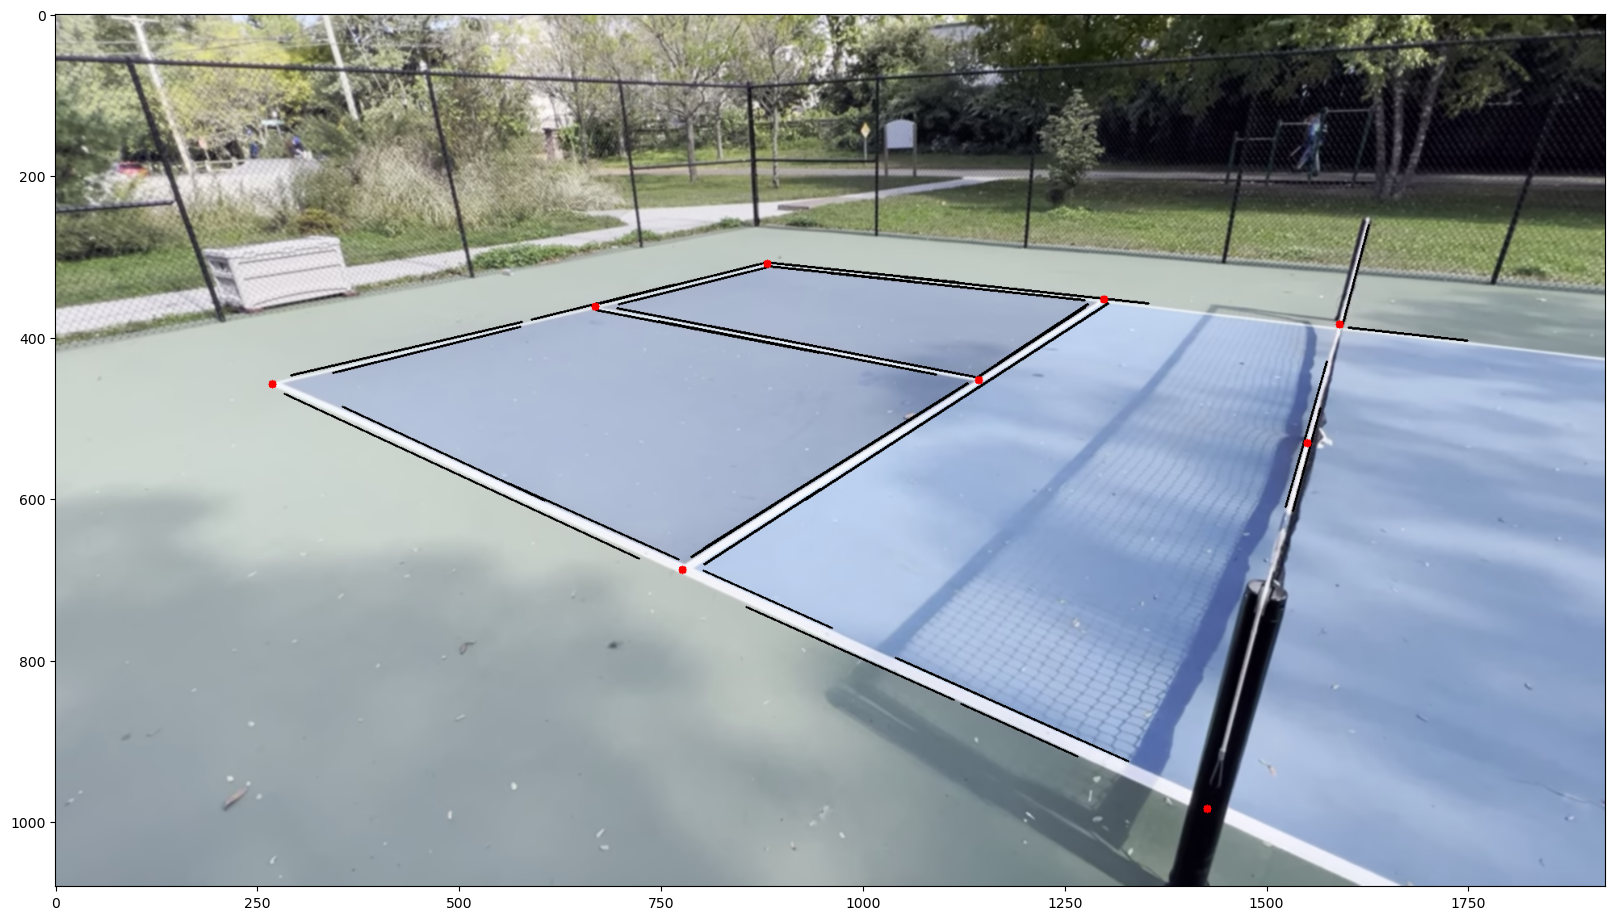

In [36]:
# compute center of each cluster by using the min and max x and y values
centers = {}
counts = {}

for i in range(n_clusters_):
    cluster = intersection_points[labels == i]
    x_min = np.min(cluster[:,0])
    x_max = np.max(cluster[:,0])
    y_min = np.min(cluster[:,1])
    y_max = np.max(cluster[:,1])
    centers[i] = ((x_min + x_max)/2, (y_min + y_max)/2)
    counts[i] = len(cluster)
print(centers)

# plot centers
center_img = img_with_lines.copy()
# top_6_centers = sorted(centers.keys(), key = lambda x: counts[x], reverse=True)[:6]
# for i in top_6_centers:
#     x,y = centers[i]
#     cv2.circle(center_img, (int(x), int(y)), 5, (255,0,0), -1)
for (x,y) in centers.values():
    cv2.circle(center_img, (int(x), int(y)), 5, (255,0,0), -1)
show_image(center_img)


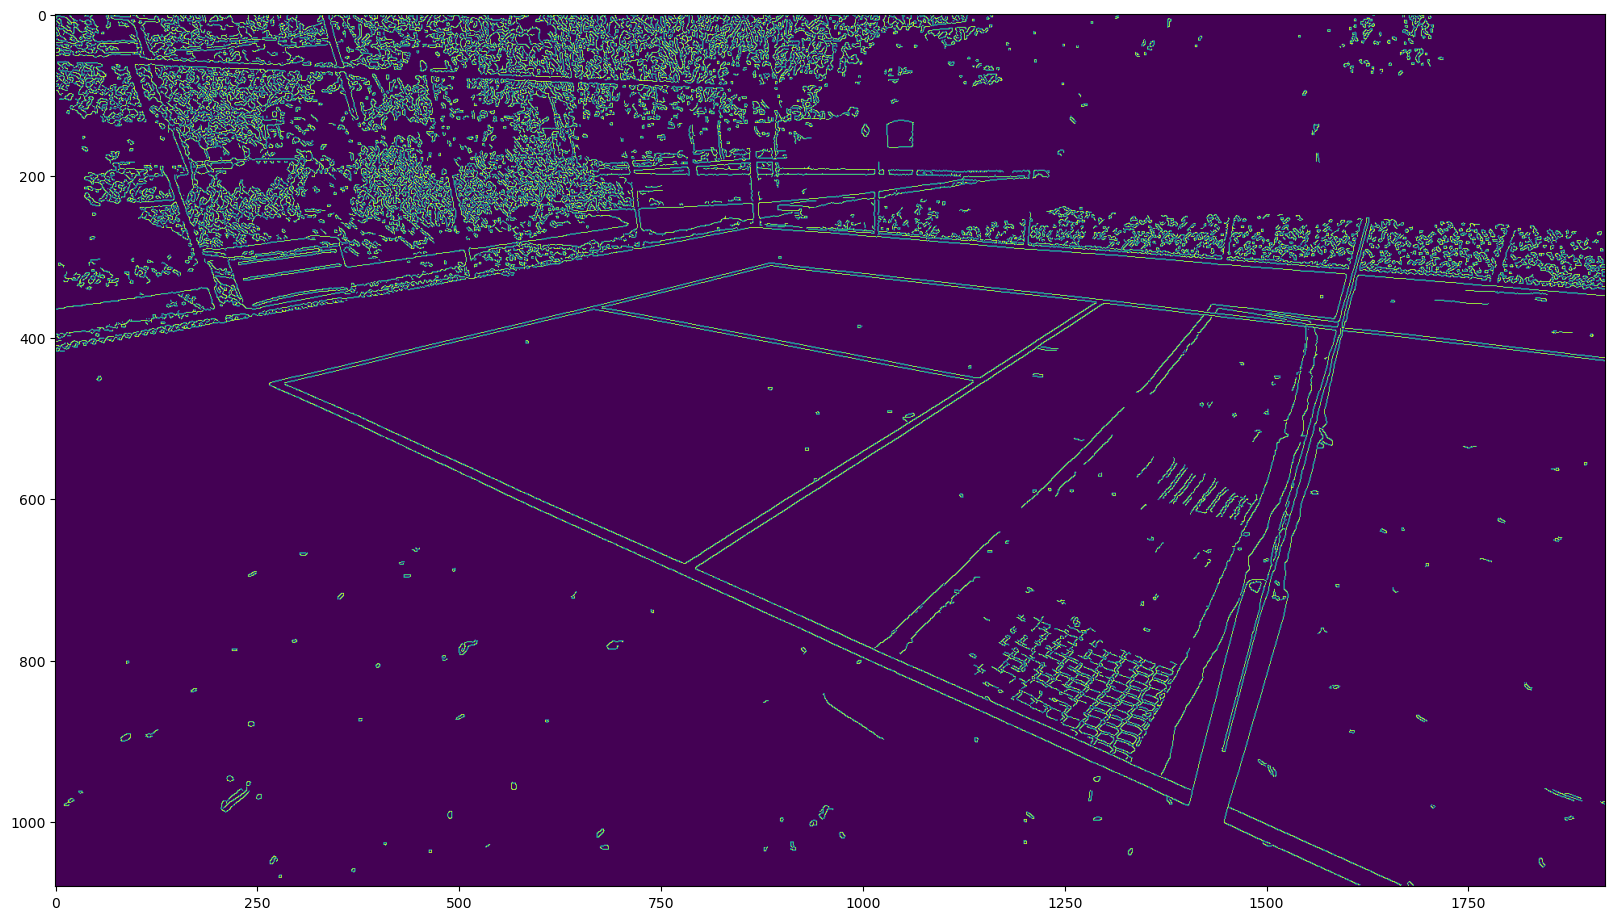

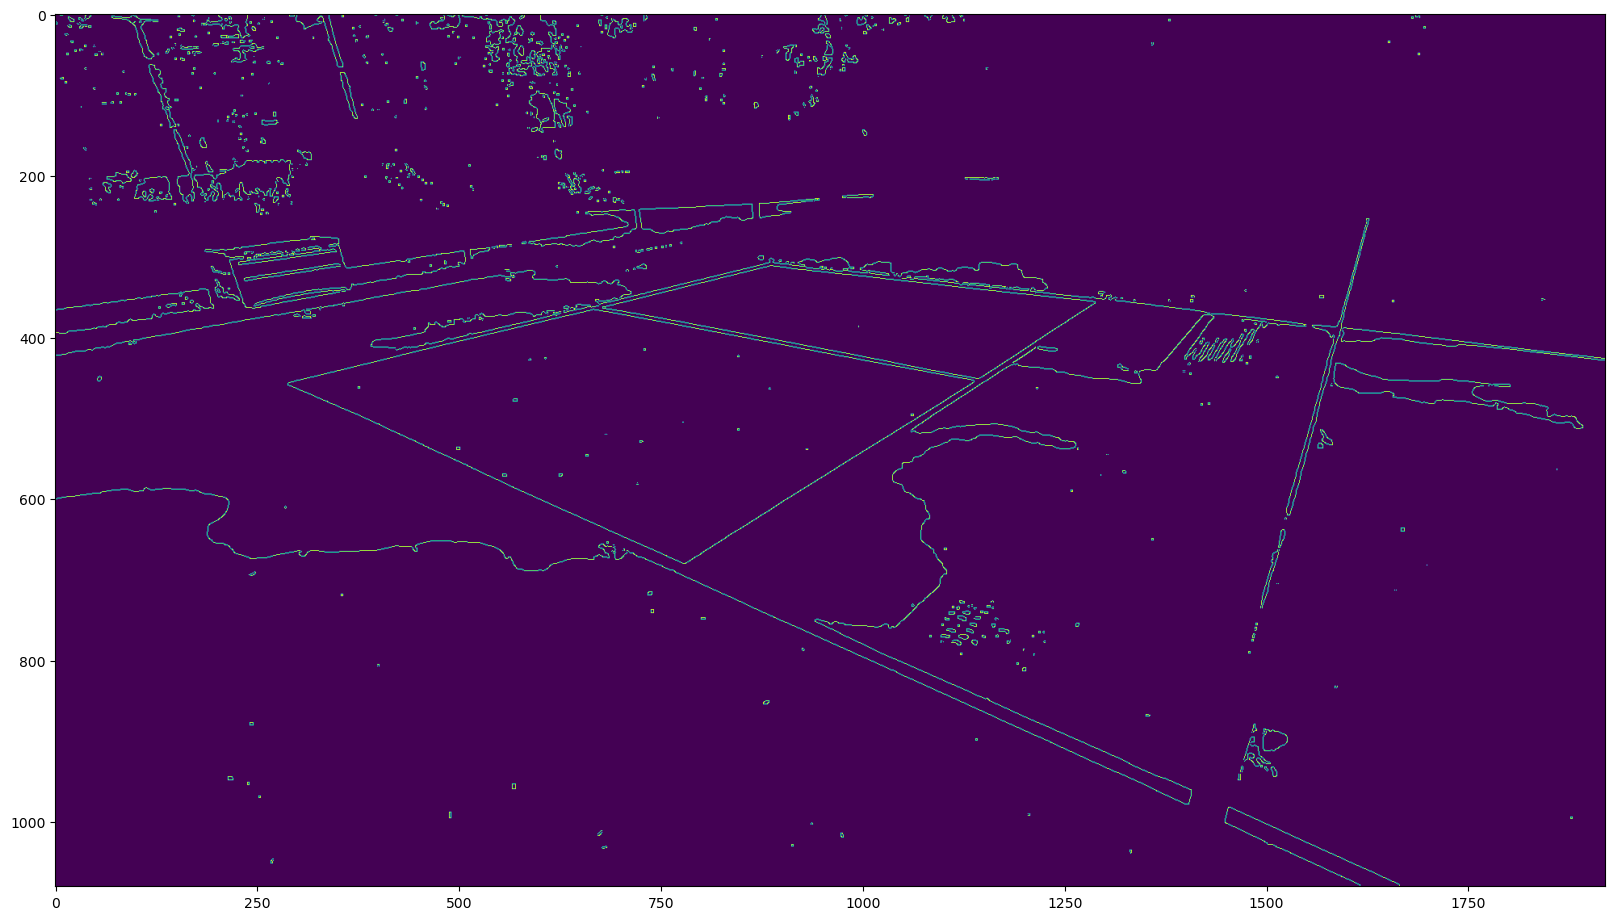

(41, 1, 4)


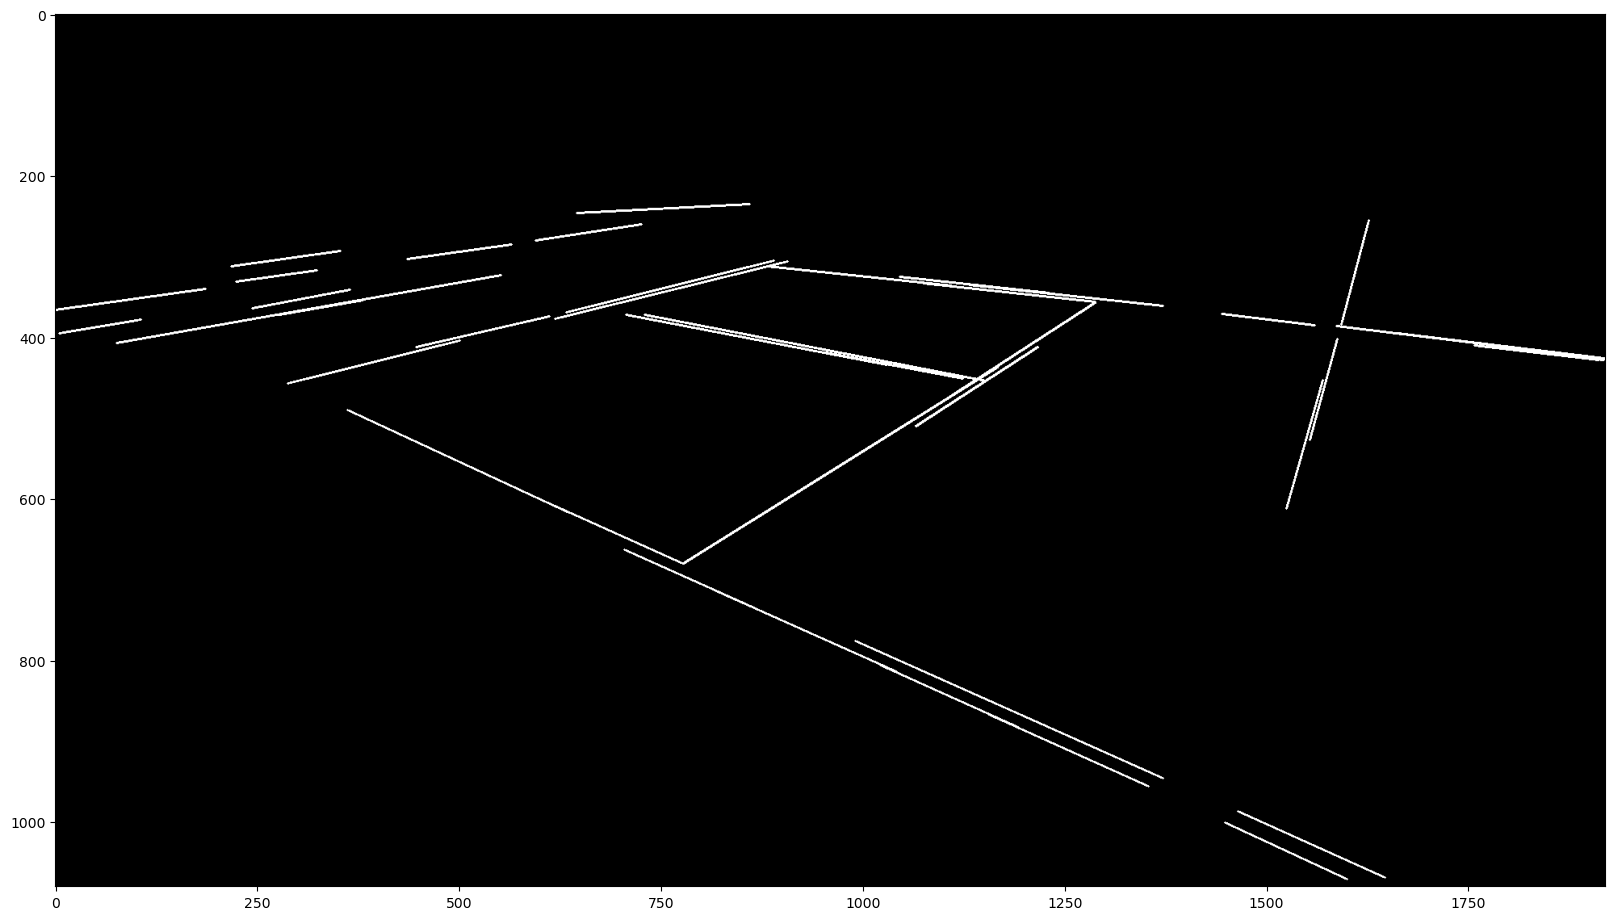

In [37]:
test_canny = cv2.Canny(img_0 * bright_mask[..., np.newaxis], 100, 200) 
show_image(cv2.Canny((img*255).astype(np.uint8), 100, 200))
show_image(test_canny)

test_lines = cv2.HoughLinesP(test_canny, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
print(test_lines.shape)
test_line_img = np.zeros((test_canny.shape[0], test_canny.shape[1], 3), dtype=np.uint8)
for line in test_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(test_line_img,(x1,y1),(x2,y2),(255,255,255),2)
show_image(test_line_img)